<a id='start'></a>
# Приоритизация гипотез и анализ результатов A/B-теста для крупного интернет-магазина

## Описание проекта

**Цель проекта** - проверка гипотез для увеличения выручки интернет-магазина.

**Задачи проекта:**
1. Приоритизировать гипотезы.
2. Проанализировать результаты A/B-теста.

**План работы:**
1. Приоритизировать гипотезы с помощью фреймворков ICE и RICE.
2. Провести графический анализ кумулятивной выручки, среднего количества заказов на пользователя и среднего чека по группам.
3. Определить границы аномальных значений по среднему количеству заказов на пользователя и среднему чеку.
4. Проанализировать статистическую значимость различий между группами по количеству заказов на пользователя и среднему чеку по "сырым" и "очищенным" данным.
5. Принять решение по результатам теста.

**Описание данных**

*Данные для первой части:*

Файл `/datasets/hypothesis.csv`
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

*Данные для второй части:*

Файл `/datasets/orders.csv`
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Содержание проекта
1. [Приоритизация гипотез](#part1)
2. [Анализ A/B теста](#part2)
3. [Выводы по результатам анализа](#part3)

<a id='part1'></a>
## 1. Приоритизация гипотез

### 1.1. Загрузка библиотек и данных

In [34]:
# загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
import seaborn as sns
pd.options.display.max_colwidth = 400

In [4]:
# изучим файлы

try:
    hypotheses = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypotheses = pd.read_csv('C:/Users/Александра/practicum/AB тестирование/hypothesis.csv')

hypotheses

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# приведём названия столбцов к нижнему регистру

hypotheses.columns = hypotheses.columns.str.lower()
hypotheses

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### 1.2. Применение фреймворка ICE для приоритизации гипотез

In [6]:
# создадим столбец "ice_score" по формуле ICE score = (Impact x Confidence) / Efforts

hypotheses['ice_score'] = round((hypotheses['impact'] * hypotheses['confidence']) / hypotheses['efforts'], 2)

# отсортируем гипотезы по убыванию показателя ICE score
hypotheses = hypotheses.sort_values(by='ice_score', ascending=False)
hypotheses

,hypothesis,reach,impact,confidence,efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


Наиболее приоритетными гипотезами, в соответствии с фреймворком ICE, будут гипотезы с индексами 8, 0 и 7:

In [7]:
hypotheses.head(3)

,hypothesis,reach,impact,confidence,efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20


### 1.3. Применение фреймворка RICE для приоритизации гипотез

In [8]:
# создадим столбец "rice_score" по формуле RICE score = (Reach x Impact x Confidence) / Efforts 

hypotheses['rice_score'] = round((hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) /
                            hypotheses['efforts'], 2)

# отсортируем гипотезы по убыванию показателя ICE score
hypotheses = hypotheses.sort_values(by='rice_score', ascending=False)
hypotheses

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


Применение фреймворка RICE привело к другому результату. Гипотезы с индексами 7 и 0 остались в числе наиболее приоритетных, однако приоритет гипотезы с индексом 8 существенно снизился:

In [9]:
hypotheses.head(5)

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2


### 1.4. Сравнение результатов приоритизации с использованием фреймворков ICE и RICE

Снижение приоритета гипотезы с индексом 8 могло произойти из-за того, что она обладает наименьшей оценкой показателя Reach. Иными словами, запустив акцию, которая даёт скидку на товар в день рождения, мы не сможем охватить большую аудиторию за тот короткий промежуток времени, в течение которого будет идти A/B-тест.

У гипотезы с индексом 7 показатель охвата, напротив, максимальный, поэтому ей удалось "выбиться" вперёд в списке гипотез, ранжированном по приоритету. Действительно: добавив форму подписки на все основные страницы сайта, мы сможем охватить максимальное количество пользователей.

In [10]:
# создадим два списка с индексами гипотез, расположенных по убыванию значений ice и rice score

ice_indices = hypotheses.sort_values(by='ice_score', ascending=False).index
rice_indices = hypotheses.sort_values(by='rice_score', ascending=False).index

# создадим из полученных списков датафрейм и выделим цветом изменение положения каждой гипотезы
# в списке, ранжированном по убыванию приоритета с помощью фреймворков ICE и RICE

ice_and_rice = pd.DataFrame(ice_indices, rice_indices).reset_index()
ice_and_rice.columns = ['ice_descending', 'rice_descending']

def make_pretty(styler):
    styler.background_gradient(cmap="YlGnBu")
    return styler

ice_and_rice.style.pipe(make_pretty)

,ice_descending,rice_descending
0,7,8
1,2,0
2,0,7
3,6,6
4,8,2
5,3,1
6,1,5
7,5,3
8,4,4


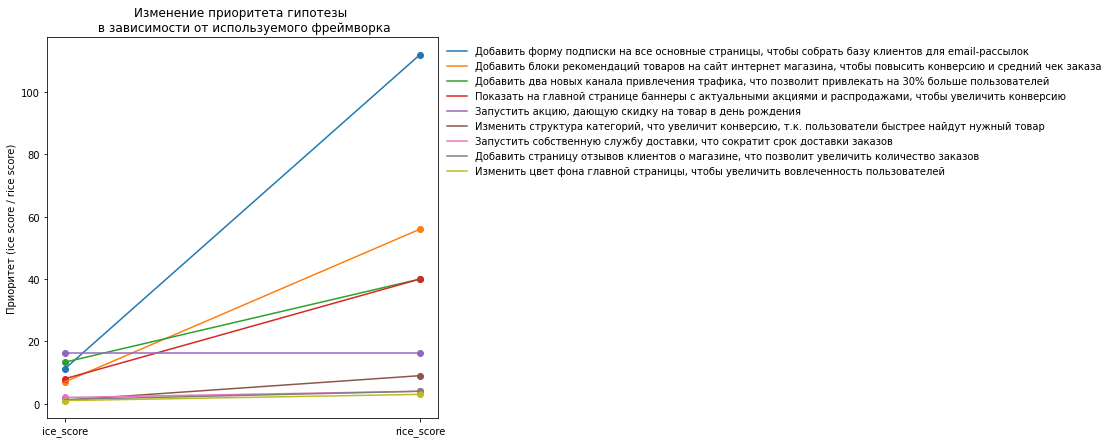

In [12]:
# визуализируем изменение приоритетов гипотез с помощью слоупграфа

h_names = hypotheses['hypothesis']

fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)
for i in h_names:
    temp = hypotheses[hypotheses['hypothesis'] == i]
    plt.scatter(x=['ice_score', 'rice_score'], 
                y=[temp.ice_score, temp.rice_score])
    plt.plot(['ice_score', 'rice_score'], 
                [temp.ice_score, temp.rice_score])
    
ax.set_title('Изменение приоритета гипотезы \n в зависимости от используемого фреймворка')
ax.set_ylabel('Приоритет (ice score / rice score)')
ax.legend(hypotheses['hypothesis'], frameon=False, bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.show()

<a id='part2'></a>
## Часть 2. Анализ A/B-теста

### 2.1. Загрузка и предобработка данных

In [13]:
# загрузим данные и изучим результаты проведения A/B-теста

try:
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    orders = pd.read_csv('C:/Users/Александра/practicum/AB тестирование/orders.csv')
    visitors = pd.read_csv('C:/Users/Александра/practicum/AB тестирование/visitors.csv')

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [14]:
# проверим типы данных в датафрейме

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [15]:
# скорректируем тип данных столбца date

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [16]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
# проверим типы данных в датафрейме

visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [18]:
# скорректируем тип данных столбца date

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [19]:
# проверим данные на наличие дубликатов

print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


В обоих датафреймах отсутствуют явные дубликаты.

In [20]:
# проверим корректность разбиения пользователей на группы

visitor_group = orders[['visitorId', 'group']].drop_duplicates()
visitor_group['visitorId'].duplicated().sum()

58

В датафрейме обнаружено 58 пользователей, которые были отнесены и к группе A, и к группе B. Проверим, сколько заказов совершили данные пользователи.

In [26]:
duplicatedIds = visitor_group[visitor_group['visitorId'].duplicated()]['visitorId']
orders[orders['visitorId'].isin(duplicatedIds)].shape

(181, 5)

Пользователями, которые были одновременно определены и в группу A, и в группу B, был совершён 181 заказ, что составляет 181/1197 = 15.1% от изначальной выборки. Это довольно большое значение, которое может негативно сказаться на результатах теста.

Избавимся от данных записей в датафрейме *orders*. Для датафрейма *visitors* необходимо определить, в какие даты выявленные пользователи совершали покупки и в какую группу они попали, после чего уменьшить значение столбца visitors на соответствующее количество посетителей.

In [27]:
orders = orders[~orders['visitorId'].isin(duplicatedIds)].reset_index(drop=True)
print(orders.shape)
orders.head()

(1016, 5)


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B


### 2.2. Анализ кумулятивной выручки по группам

In [28]:
# создадим массив уникальных пар значений дат и групп теста

datesGroups = orders[['date','group']].drop_duplicates()

# агрегируем полученные значения

ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                           orders['group'] == x['group'])]
                           .agg({'date' : 'max',
                                 'group' : 'max',
                                 'transactionId' : 'nunique',
                                 'visitorId' : 'nunique',
                                 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
)

ordersAggregated.head(6)

,date,group,transactionId,visitorId,revenue
45,2019-08-01,A,23,19,142779
54,2019-08-01,B,17,17,59758
149,2019-08-02,A,42,36,234381
147,2019-08-02,B,40,39,221801
245,2019-08-03,A,66,60,346854
328,2019-08-03,B,54,53,288850


In [30]:
# получим кумулятивные данные о посетителях интернет-магазина, агрегированные по дням

visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                               visitors['group'] == x['group'])]
                             .agg({'date' : 'max',
                                  'group' : 'max',
                                  'visitors': 'sum'}), axis=1)
                      .sort_values(by=['date', 'group'])
)

visitorsAggregated.head(6)

,date,group,visitors
45,2019-08-01,A,719
54,2019-08-01,B,713
149,2019-08-02,A,1338
147,2019-08-02,B,1294
245,2019-08-03,A,1845
328,2019-08-03,B,1803


In [31]:
# объединим кумулятивные данные в одной таблице

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


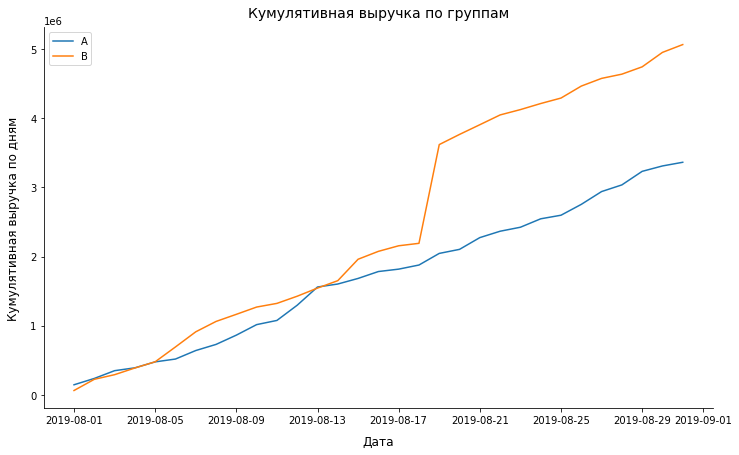

In [35]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# построим график выручки группы А
plt.figure(figsize=(12, 7))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# построим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам', fontsize=14, pad=10)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel('Кумулятивная выручка по дням', fontsize=12, labelpad=10)
plt.legend()
sns.despine()
plt.show()

По графику кумулятивной выручки по группам можем заметить, что кумулятивная выручка в группе B стабильно выше, чем в группе A, однако выручка в группе A растёт довольно равномерно, в то время как **в группе B наблюдается резкий всплеск выручки между 17 и 21 августа, после чего темпы роста выручки в обеих группах становятся одинаковыми**. Это может сигнализировать о **всплесках числа заказов либо о появлении очень дорогих заказов в выборке.**

### 2.3. Анализ кумулятивного среднего чека по группам

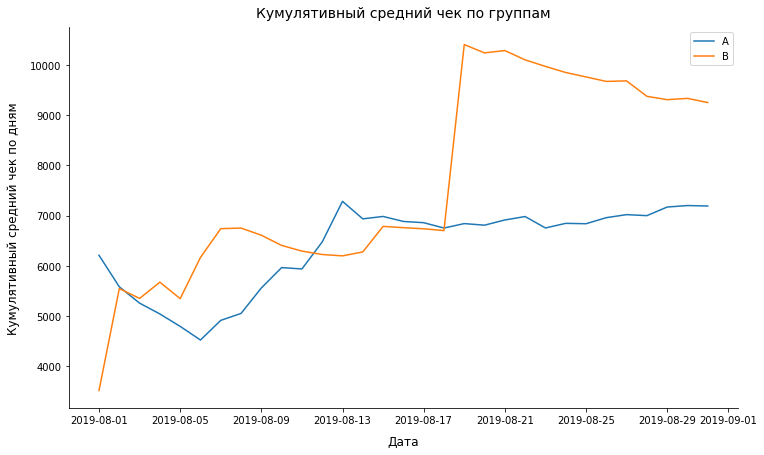

In [36]:
# построим графики среднего чека по группам

plt.figure(figsize=(12, 7))
plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Кумулятивный средний чек по группам', fontsize=14, pad=10)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel('Кумулятивный средний чек по дням', fontsize=12, labelpad=10)
plt.legend()
sns.despine()
plt.show()

Кумулятивный средний чек в обеих группах не равномерен и стабилизируется только к окончанию теста, при этом средний чек в группе B к концу теста снижается. Это может быть обусловлено тем, что **в выборку в группу B попали слишком крупные заказы** (на графике виден резкий всплеск среднего чека между 17 и 21 августа).

### 2.4. Анализ относительного изменения кумулятивного среднего чека

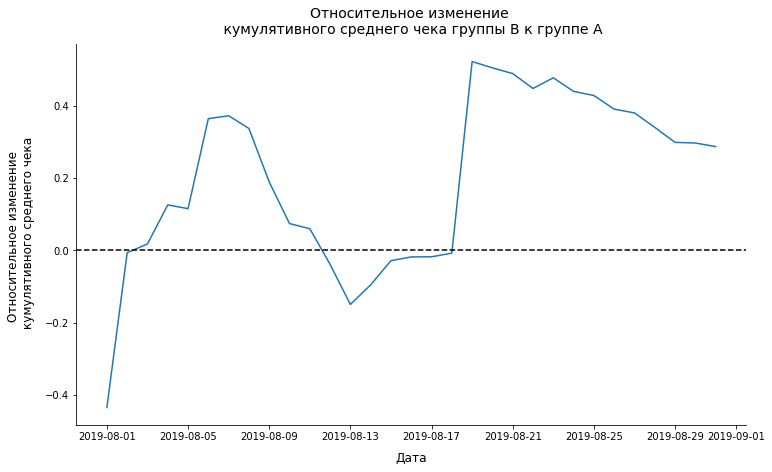

In [38]:
# соберём данные в одном датафрейме
mergedCumulativeRevenue = (cumulativeRevenueA
                           .merge(cumulativeRevenueB,
                                  left_on='date', right_on='date', how='left',
                                  suffixes=['A', 'B']))

# поcтроим отношение средних чеков
plt.figure(figsize=(12, 7))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавим ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительное изменение \n кумулятивного среднего чека группы B к группе A',
          fontsize=14, pad=10)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel('Относительное изменение \n кумулятивного среднего чека', fontsize=12, labelpad=10)

sns.despine()
plt.show()

График имеет довольно много резких "скачков", что говорит о **наличии аномальных значений** (возможно, как чрезмерно крупных в группе B во второй половине теста, так и чрезмерно мелких в группе A в первой половине теста).

### 2.5. Анализ кумулятивного среднего количества заказов на посетителя по группам

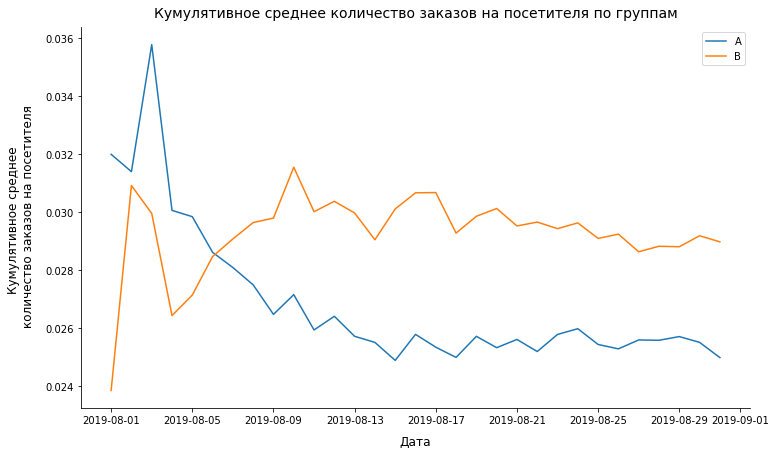

In [39]:
# посчитаем среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделим данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделим данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# построим графики
plt.figure(figsize=(12, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.title('Кумулятивное среднее количество заказов на посетителя по группам', fontsize=14, pad=10)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel('Кумулятивное среднее \n количество заказов на посетителя', fontsize=12, labelpad=10)

sns.despine()
plt.show()

В самом начале теста в обеих группах наблюдается резкий всплеск и такое же резкое падение среднего количества заказов на посетителя, однако после этого тендеция меняется: среднее количество заказов в группе B становится существенно больше, чем аналогичный показатель в группе A.

### 2.6. Анализ относительного изменения кумулятивного среднего количества заказов

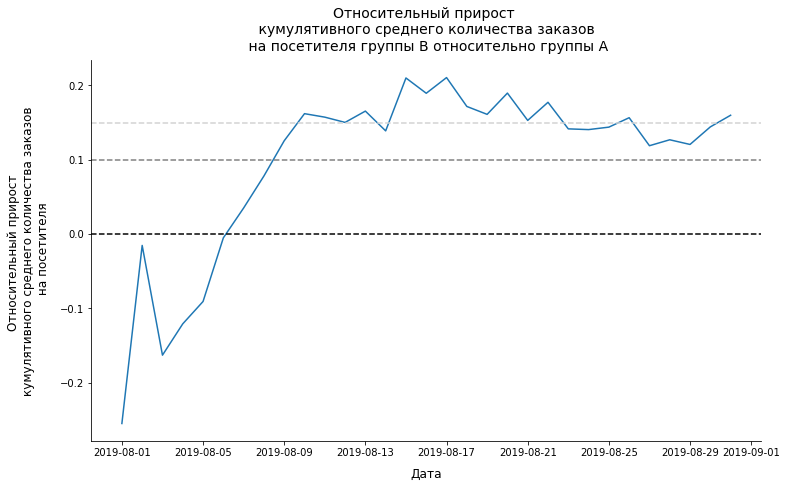

In [40]:
# построим график относительного изменения 
# кумулятивного среднего количества заказов на посетителя группы B к группе A

mergedCumulativeConversions = (cumulativeDataA[['date','conversion']]
                               .merge(cumulativeDataB[['date','conversion']],
                                      left_on='date', right_on='date', how='left',
                                      suffixes=['A', 'B']))
plt.figure(figsize=(12, 7))
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.title('Относительный прирост \n кумулятивного среднего количества заказов \
\n на посетителя группы B относительно группы A', fontsize=14, pad=10)
plt.xlabel('Дата', fontsize=12, labelpad=10)
plt.ylabel('Относительный прирост \n кумулятивного среднего количества заказов \n на посетителя',
           fontsize=12, labelpad=10)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axhline(y=0.15, color='lightgrey', linestyle='--')

sns.despine()
plt.show()

На графике заметно, что среднее количество заказов в группе B было ниже аналогичного показателя в группе A только в самом начале теста с одним "всплеском". Однако впоследствии посетители, попавшие в группу B, совершали на порядок больше заказов, чем посетители группы A, при этом показатель относительного прироста продолжает расти.

Однако несмотря на положительную тенденцию в группе B, делать выводы по тесту ещё рано - отношение среднего количества заказов на посетителя ещё не установилось.

### 2.7. Анализ количества заказов по пользователям

In [41]:
# сгруппируем данные о количестве заказов по пользователям

ordersByUsers = (orders
                 .groupby('visitorId', as_index=False)
                 .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


В выборке присутствуют пользователи, которые совершили 2-3 заказа. Проверим разброс количества заказов по пользователям с помощью точечного графика.

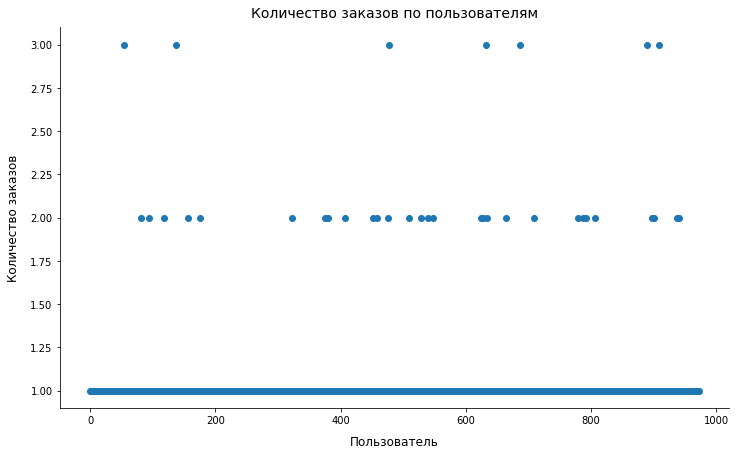

In [42]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.figure(figsize=(12, 7))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Количество заказов по пользователям', fontsize=14, pad=10)
plt.xlabel('Пользователь', fontsize=12, labelpad=10)
plt.ylabel('Количество заказов', fontsize=12, labelpad=10)
sns.despine()
plt.show()

Из графика видно: в выборке присутствует довольно много пользователей с 1 заказом. Пользователей с 2-3 заказами меньше, однако пока нельзя сделать вывод о том, признавать ли эти значения выбросами.

### 2.8. Анализ 95-го и 99-го перцентилей количества заказов на пользователя

In [43]:
# посчитаем выборочные перцентили количества заказов на одного пользователя

np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей совершили более 1 заказа за время проведения теста и не более 1% пользователей - более 2 заказов. **Целесообразно установить 2 заказа за верхнюю границу числа заказов на пользователя и отсеять аномальных пользователей по ней.**

### 2.9. Анализ стоимости заказов

In [44]:
# сгруппируем данные о стоимости заказов по пользователям

ordersByUsers = (orders
                 .groupby('visitorId', as_index=False)
                 .agg({'revenue': 'mean'})
)
ordersByUsers.columns = ['visitorId', 'revenue']
ordersByUsers.sort_values(by='revenue', ascending=False).head(10)

,visitorId,revenue
440,1920142716,1294500.0
477,2108080724,202740.0
300,1307669133,92550.0
202,888512513,86620.0
938,4133034833,67990.0
267,1164614297,66350.0
25,148427295,65710.0
200,887908475,60450.0
915,4003628586,58550.0
514,2254456485,53904.0


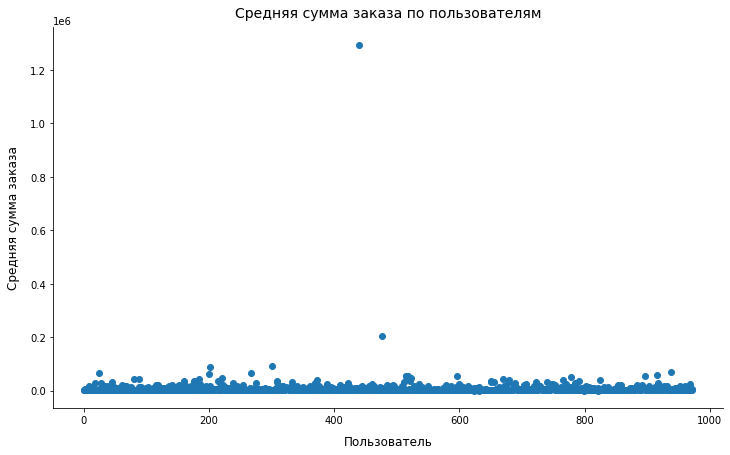

In [45]:
# построим точечный график стоимости заказов по пользователям

plt.figure(figsize=(12, 7))
plt.scatter(x_values, ordersByUsers['revenue'])
plt.title('Средняя сумма заказа по пользователям', fontsize=14, pad=10)
plt.xlabel('Пользователь', fontsize=12, labelpad=10)
plt.ylabel('Средняя сумма заказа', fontsize=12, labelpad=10)
sns.despine()
plt.show()

Исходя из графика, очевидны 2 выброса по средней стоимости заказов на пользователя: 1 294 500 руб. и 202 740 руб.

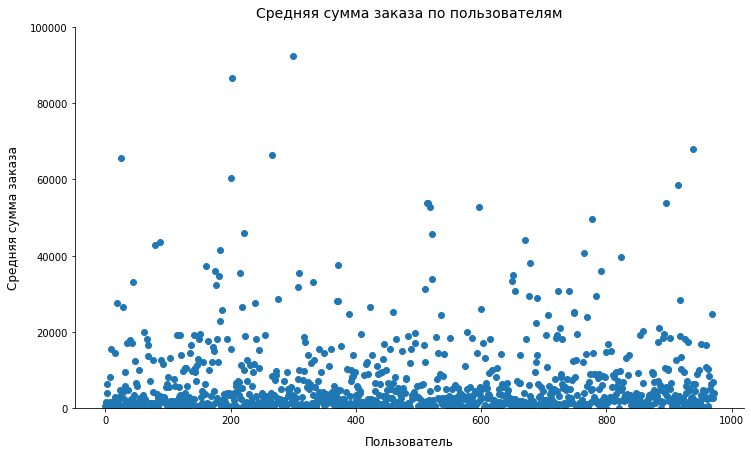

In [46]:
# рассмотрим график более тщательно

plt.figure(figsize=(12, 7))
plt.scatter(x_values, ordersByUsers['revenue'])
plt.ylim(0, 100000)
plt.title('Средняя сумма заказа по пользователям', fontsize=14, pad=10)
plt.xlabel('Пользователь', fontsize=12, labelpad=10)
plt.ylabel('Средняя сумма заказа', fontsize=12, labelpad=10)
sns.despine()
plt.show()

Заказов больше 20 тыс. руб. тоже немного - необходимо понять, являются ли они аномальными.

### 2.10. Анализ 95-го и 99-го перцентилей стоимости заказов

In [47]:
# посчитаем выборочные перцентили количества заказов на одного пользователя

np.percentile(ordersByUsers['revenue'], [95, 99])

array([27754., 53904.])

Не более 5% пользователей совершали заказы в среднем на 27 754 руб. и не более 1% пользователей - в среднем на 53 904 руб. **Установим 27 754 руб. (95-ый перцентиль) за верхнюю границу числа заказов на пользователя и отсеем аномальных пользователей по ней.**

### 2.11. Анализ статистической значимости различий в среднем количестве заказов на посетителя ("сырые" данные)

In [48]:
# подготовим "сырые" данные для анализа

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACumulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACumulative.columns = ['date', 'visitorsCumulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCumulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCumulative.columns = ['date', 'visitorsCumulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACumulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACumulative.columns = [
    'date',
    'ordersCumulativeA',
    'revenueCumulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCumulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCumulative.columns = [
    'date',
    'ordersCumulativeB',
    'revenueCumulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACumulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCumulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACumulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCumulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCumulativeA,revenueCumulativeA,ordersCumulativeB,revenueCumulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCumulativeA,visitorsCumulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Сформулируем **нулевую и альтернативную гипотезы** для тестирования:

**H0:** Нет различий между средним количеством заказов на пользователя в группе B и средним количеством заказов на пользователя в группе A.

**H1:** Есть различия между средним количеством заказов на пользователя в группе B и средним количеством заказов на пользователя в группе A.

In [49]:
# создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']
# в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

# объявим переменные sampleA и sampleB, в которых пользователям из разных групп
# будет соответствовать количество заказов

sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - 
                                                  len(ordersByUsersA['orders'])),
                               name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() -
                                                  len(ordersByUsersB['orders'])),
                               name='orders')],axis=0)

# посчитаем статистическую значимость различия в среднем количестве заказов между группами

print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительное превосходство среднего кол-ва заказов на пользователя \n \
в группе B над аналогичным показателем в группе A:', 
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Относительное превосходство среднего кол-ва заказов на пользователя 
 в группе B над аналогичным показателем в группе A: 0.160


p-value < 0.05 => по «сырым» данным мы отвергаем нулевую гипотезу и делаем вывод: **между средним числом заказов на пользователя в группах A и B есть статистически значимые различия**. Заметим, что если бы тест проводился на уровне значимости 1%, то нулевая гипотеза не была бы отвергнута => целесообразно впоследствии проверить результаты теста на "очищенных" данных.

При этом относительное превосходство среднего количества заказов в группе B над аналогичным показателем в группе A составляет 16.0%.

### 2.12. Анализ статистической значимости различий в среднем чеке заказа ("сырые" данные)

Сформулируем **нулевую и альтернативную гипотезы** для тестирования:

**H0:** Нет различий между средним чеком заказа в группе B и средним чеком заказа в группе A.

**H1:** Есть различия между средним чеком заказа в группе B и средним чеком заказа в группе A.

In [50]:
# посчитаем статистическую значимость различия в среднем чеке заказа между группами

print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительное превосходство среднего чека заказа \n в группе B над аналогичным показателем в группе A:',
      "{0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/
                       orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Относительное превосходство среднего чека заказа 
 в группе B над аналогичным показателем в группе A: 0.287


p-value >> 0.05 => по «сырым» данным мы не можем отвергнуть нулевую гипотезу и делаем вывод: **между средним чеком заказа в группе B и средним чеком заказа в группе A статистически значимых различий нет**.

Таким образом, наблюдаемое относительное превосходство среднего чека заказа в группе B над аналогичным показателем в группе A в 28.7% не является статистически значимым.

### 2.13. Анализ статистической значимости различий в среднем количестве заказов на посетителя ("очищенные" данные)

In [53]:
# узнаем, сколько всего аномальных пользователей

revenue_lim = np.percentile(orders['revenue'], 95)
orders_lim = np.percentile(pd.concat([ordersByUsersA, ordersByUsersB], axis=0)['orders'], 99)

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_lim]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_lim]['visitorId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print()
print(f"Аномальных пользователей: {abnormalUsers.shape[0]}")

487    113298937
937    148427295
792    204675465
33     249864742
586    358944393
Name: visitorId, dtype: int64

Аномальных пользователей: 58


Всего **58 аномальных пользователей**.

Сформулируем **нулевую и альтернативную гипотезы** для тестирования:

**H0:** Нет различий между средним количеством заказов на пользователя в группе B и средним количеством заказов на пользователя в группе A.

**H1:** Есть различия между средним количеством заказов на пользователя в группе B и средним количеством заказов на пользователя в группе A.

In [54]:
# подготовим "очищенные" данные для анализа

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# посчитаем статистическую значимость различия в среднем количестве заказов между группами
# по "очищенным" данным

print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительное превосходство среднего кол-ва заказов на пользователя \n \
в группе B над аналогичным показателем в группе A:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.012
Относительное превосходство среднего кол-ва заказов на пользователя 
 в группе B над аналогичным показателем в группе A: 0.182


Показатели изменились незначительно. p-value немного увеличилось, однако осталось всё ещё меньше 0.05 => по «очищенным» данным мы отвергаем нулевую гипотезу и делаем вывод: **между средним числом заказов на пользователя в группах A и B есть статистически значимые различия**.

При этом относительное превосходство среднего количества заказов в группе B над аналогичным показателем в группе A составляет 18.2%.

### 2.14. Анализ статистической значимости различий в среднем чеке заказа ("очищенные" данные)

Сформулируем **нулевую и альтернативную гипотезы** для тестирования:

**H0:** Нет различий между средним чеком заказа в группе B и средним чеком заказа в группе A.

**H1:** Есть различия между средним чеком заказа в группе B и средним чеком заказа в группе A.

In [55]:
# посчитаем статистическую значимость различия в среднем чеке заказа между группами
# по "очищенным" данным

print('p-value:', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительное превосходство среднего чека заказа \n в группе B над аналогичным показателем в группе A:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.646
Относительное превосходство среднего чека заказа 
 в группе B над аналогичным показателем в группе A: -0.048


p-value >>> 0.05 => по «очищенным» данным мы также не можем отвергнуть нулевую гипотезу и делаем вывод: **между средним чеком заказа на пользователя в группах A и B статистически значимых различий нет**.

Однако произошло существенное изменение относительного превосходства. Если по "сырым" данным средний чек в группе B был больше среднего чека в группе A на 28.7%, то теперь превосходство стало отрицательным. Иными словами, исключение аномалий из выборки позволило отметить, что на самом деле средний чек в группе B меньше среднего чека в группе A на 4.8% (хотя эта разница и не является статистически значимой).

### Решение по результатам теста

Зафиксируем ключевые выводы теста:
1. Между средним количеством заказов на пользователя в группах A и B есть статистически значимые различия - этот вывод подтверждается и на «сырых» данных, и на данных после фильтрации аномалий.
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым» данным, ни по данным после фильтрации аномалий.
3. График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A, при этом в последней трети A/B-теста соотношение стабилизировалось.
4. График различия среднего чека говорит о том, что результаты группы B лучше группы A, однако есть тенденция к ухудшению.

Исходя из полученных результатов, можно предложить **завершить тест и зафиксировать победу группы B**. Между группами A и B нет различий в средним чеке заказа, однако статистически значимые различия были обнаружены между группами в количестве заказов на пользователя: пользователи в группе B в среднем заказывали на 18.2% чаще, чем пользователи в группе A.

<a id='part3'></a>
## Выводы по результатам анализа

Данный проект был посвящён приоритизации бизнес-гипотез и анализу результатов A/B-теста.

По итогам работы были получены следующие выводы:

1. **Наиболее приоритетными** для тестирования являются гипотезы:
- **Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;**
- **Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.**

Первая гипотеза обладает максимальным показателем охвата (Reach = 10), в то время как вторая - в большей степени может оказать влияние на пользователей (Impact = 10). Обе гипотезы примерно одинаковы в затратах на тестирование (Efforts_1 = 5, Efforts_2 = 6).

2. По результатам анализа A/B-теста была сформулирована рекомендация о необходимости **продолжения теста**. Полученный вывод обусловлен следующими факторами:
- **Между средним количеством заказов на пользователя в группах A и B есть статистически значимые различия** - этот вывод подтверждается и на «сырых» данных, и на данных после фильтрации аномалий (p-value < 0.05).
- **Нет статистически значимого различия по среднему чеку между группами A и B ни по «сырым» данным, ни по данным после фильтрации аномалий** (p-value >> 0.05). Влияние аномалий на различия в среднем чеке между группами оказалось существенным: если с ними средний чек в группе B превосходил средний чек в группе A на 28.7%, то анализ «очищенных» данных продемонстрировал, что средний чек в группе B на самом деле ниже аналогичного показателя в группе A на 4.8%. Тем не менее, выявленные различия не являются статистически значимыми ни в первом, ни во втором случае.
- График различия **среднего количества заказов** между группами сообщает, что **результаты группы B лучше группы A, при этом в последней трети A/B-теста соотношение стабилизировалось**.
- График различия **среднего чека** говорит о том, что **результаты группы B лучше группы A, однако есть тенденция к ухудшению**.

Таким образом, с учётом полученных результатов, рекомендуется **остановить тест и зафиксировать победу группы B**. Различий в среднем чеке между группами нет, однако количество заказов на пользователя в группе B на 18.2% больше, чем аналогичный показатель в группе A.

**[В начало](#start)**